In [1]:
import pandas as pd
from scipy.optimize import broyden1
import math
import scipy.optimize as opt
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model

In [2]:
# Define helper functions
def u(c, gamma):
    return c ** (1 - gamma) / (1 - gamma)
def u_dash(c, gamma):
    return c ** (-gamma)
def mtp1(ctp1, ct, beta, gamma):
    return beta * u_dash(ctp1, gamma) / u_dash(ct, gamma)

In [3]:
# Load files
# Quarterly measure of inflation
gdp_def = pd.read_csv("GDPDEF.csv", index_col='DATE')
gdp_def.index = pd.to_datetime(gdp_def.index)
# Quarterly personal consumption expenditure
pers_cons = pd.read_csv("PCECC96.csv", index_col='DATE') 
pers_cons.index = pd.to_datetime(pers_cons.index)
# Montly risk free rate
riskf_rate = pd.read_csv("TB3MS.csv", index_col='DATE') 
riskf_rate.index = pd.to_datetime(riskf_rate.index)
# Returns to the aggregate U.S. stock market ##to quarterly ##account for inflation
returns = pd.read_csv("WILL5000INDFC.csv", na_values='.', index_col='DATE')  
returns.dropna(inplace=True)
returns.index = pd.to_datetime(returns.index)

Note that you will need to transform the Wilshire 5000 series and the T-Bill series into quarterly data as well as calculate the real returns to the Wilshire 5000 by accounting for inflation

In [4]:
# Converting risk free data to quarterly data
riskf_rate_q = riskf_rate.resample('Q-JAN', convention='end').agg('mean')
riskf_rate_q.index = riskf_rate_q.index.values.astype('datetime64[M]')
riskf_rate_q.head()

,TB3MS
1934-01-01,0.720000
1934-04-01,0.336667
1934-07-01,0.153333
1934-10-01,0.223333
1935-01-01,0.226667


In [5]:
returns_q = returns.resample('Q-JAN', convention='end').agg('mean')
returns_q.index = returns_q.index.values.astype('datetime64[M]')
returns_q.head()

,WILL5000INDFC
1980-10-01,2.388000
1981-01-01,2.504426
1981-04-01,2.499677
1981-07-01,2.561250
1981-10-01,2.407188


In [6]:
data = pd.merge(gdp_def, pers_cons, left_index=True, right_index=True, how='inner')
data = pd.merge(data, riskf_rate_q, left_index=True, right_index=True, how='inner')
data = pd.merge(data, returns_q, left_index=True, right_index=True, how='inner')
data.head()

,GDPDEF,PCECC96,TB3MS,WILL5000INDFC
1980-10-01,43.818,4284.494,10.340000,2.388000
1981-01-01,44.972,4298.847,14.746667,2.504426
1981-04-01,45.863,4299.160,13.946667,2.499677
1981-07-01,46.726,4319.047,15.326667,2.561250
1981-10-01,47.534,4289.504,14.583333,2.407188


In [7]:
c = data['PCECC96']
inflation = (data['GDPDEF'] - data['GDPDEF'].shift(1)) / data['GDPDEF']
per_del_returns = (data['WILL5000INDFC'] - data['WILL5000INDFC'].shift(1)) / data['WILL5000INDFC']
R = 1 + per_del_returns - inflation
rf = data['TB3MS'] / 400 - inflation

In [8]:
# Problem 2.1
beta = 0.99
def solver(gamma):
    mtp1_arr = [mtp1(c[t+1], c[t], beta, gamma) for t in range(len(c)-1)]
    E_mtp1 = np.mean(mtp1_arr)
    E_Rtp1 = np.mean(R[1:])
    cov_mtp1_Rtp1 = np.cov(mtp1_arr, R[1:])[0][1]
    eq = cov_mtp1_Rtp1 + E_mtp1 * E_Rtp1 - 1
    return eq

gamma1 = broyden1(solver, 0.1)
print('value of gamma is: ', gamma1)

value of gamma is:  0.9826977053538782


In [9]:
# Problem 2.2

In [10]:
# Problem 2.3
def solver2(gamma):
    mtp1_arr = [mtp1(c[t+1], c[t], beta, gamma) for t in range(len(c)-1)]
    E_mtp1 = np.mean(mtp1_arr)
    eq = 1 + np.mean(rf) - 1 / E_mtp1
    return eq
gamma2 = broyden1(solver2, 0.1)
print('value of gamma is: ', gamma2)

value of gamma is:  -0.7909960221370886


In [11]:
# Problem 2.4
def data_moments(data):
    R, rf = data
    E_mtp1 = 1 / (1 + np.mean(rf))
    E_Rtp1 = np.mean(R[1:])
    return (E_mtp1, E_Rtp1)

def model_moments(params, data):
    beta, gamma = params
    c, R = data
    mtp1_arr = [mtp1(c[t+1], c[t], beta, gamma) for t in range(len(c)-1)]
    E_mtp1 = np.mean(mtp1_arr)
    cov_mtp1_Rtp1 = np.cov(mtp1_arr, R[1:])[0][1]
    E_Rtp1 = (1 - cov_mtp1_Rtp1) / E_mtp1
    return (E_mtp1, E_Rtp1)

def err_vec(c, R, rf, beta, gamma):
    data1 = (R, rf)
    data_moms = np.array(data_moments(data1))
    params = (beta, gamma)
    data2 = (c, R)
    model_moms = np.array(model_moments(params, data2))
    err_vec = (model_moms - data_moms) / data_moms
    return err_vec

def criterion(params, *args):
    beta, gamma = params
    c, R, rf, W = args
    err = err_vec(c, R, rf, beta, gamma)
    crit_val = float(err.reshape(1, len(err)) @ np.eye(2) @ err.reshape(len(err),1))
    return crit_val

In [12]:
beta_init, gamma_init = 0.9, 0.9
w_hat = np.eye(2)
params_init = (beta_init, gamma_init)
gmm_args = (c, R, rf, w_hat)
results = opt.minimize(criterion,
                       params_init, 
                       args=(gmm_args),
                       tol=1e-14, 
                       method='L-BFGS-B', 
                       bounds=((1e-5, 1-1e-5), (1e-5, None)))
gmm_beta, gmm_gamma = results.x
new_err = err_vec(c, R, rf, gmm_beta, gmm_gamma)
w_new = (1 / len(R[1:])) * new_err.reshape(len(new_err),1) @ new_err.reshape(1, len(new_err))
gmm_args = (c, R, rf, w_new)
results = opt.minimize(criterion,
                       params_init, 
                       args=(gmm_args),
                       tol=1e-14, 
                       method='L-BFGS-B', 
                       bounds=((1e-5, 1-1e-5), (1e-5, None)))
results.x

array([0.99999   , 1.47138504])

Problem 2

In [13]:
files = ["AAPL", "C", "GBX", "SPY", "THO"]
for file in files:
    original = file 
    destination = file
    content = ''
    outsize = 0
    with open(original, 'rb') as infile:
        content = infile.read()
    with open(destination, 'wb') as output:
        for line in content.splitlines():
            outsize += len(line) + 1
            output.write(line + str.encode('\n'))
    print("Done. Saved %s bytes." % (len(content)-outsize))

Done. Saved 0 bytes.
Done. Saved 0 bytes.
Done. Saved 0 bytes.
Done. Saved 0 bytes.
Done. Saved 0 bytes.


In [14]:
import pickle
pickle_AAPL = open('AAPL', 'rb')
AAPL = pickle.load(pickle_AAPL)

pickle_C = open('C', 'rb')
C = pickle.load(pickle_C)

pickle_GBX = open('GBX', 'rb')
GBX = pickle.load(pickle_GBX)

pickle_SPY = open('SPY', 'rb')
SPY = pickle.load(pickle_SPY)

pickle_THO = open('THO', 'rb')
THO = pickle.load(pickle_THO)

In [15]:
class OrderBook:
    def __init__(self, data, time, bounds):
        self.data = data
        self.time = time
        self.lb, self.ub = bounds
        self.gamma, self.beta = self.regress()
    
    def change_bounds(self, bounds):
        self.lb, self.ub = bounds
        
    def regress(self):
        new_data = self.data[(self.data['price'] > self.lb) & (self.data['price'] < self.ub)]
        X = new_data[["price"]]
        y = new_data["cum_qty"]
        lm = linear_model.LinearRegression()
        model = lm.fit(X,y)
        predictions = lm.predict(X)
        beta = lm.coef_[0]
        gamma = lm.intercept_
        if abs(beta) == float("inf"):
            beta = 4000
        return (gamma, beta)
    
    def plot(self):
        plt.scatter(self.data['price'], self.data['cum_qty'], color='b')
        xvals = np.linspace(self.lb, self.ub, 1000)
        yvals = xvals * self.beta + self.gamma
        l = 'x * ' + str(self.beta) + ' + ' + str(self.gamma) + ' = y'
        plt.plot(xvals, yvals, color='r', label=l)
        if (abs(self.lb)+abs(self.ub)) < np.inf:
            plt.xlim((self.lb, self.ub)) 
        plt.show()
        
    def get_p0(self):
        pos = self.data[self.data['cum_qty']>0].first_valid_index()
        neg = self.data[self.data['cum_qty']<0].last_valid_index()
        p1 = self.data.iloc[neg]['price']
        p2 = self.data.iloc[pos]['price']
        q1 = abs(self.data.iloc[neg]['cum_qty'])
        q2 = self.data.iloc[pos]['cum_qty']
        p0 = (p2 * q1 + p1 * q2) / (q1 + q2)
        if np.isnan(p0) or abs(p0) == float("inf"):
            return -self.gamma/self.beta
        return p0

def clean_book(book):
    clean_lst_b = []
    clean_lst_s = []
    for price, info in book.items():
        transaction = info[1]
        if transaction == 'B':
            quantity = -info[0]
            clean_lst_b.append([price, quantity])
        elif transaction == 'S':
            quantity = info[0]
            clean_lst_s.append([price, quantity])
    clean_df_b = clean_book2(clean_lst_b, 'B')
    clean_df_s = clean_book2(clean_lst_s, 'S')
    clean_df = clean_df_b.append(clean_df_s)
    clean_df.drop(columns=['quantity'], inplace=True)
    return clean_df

def clean_book2(data, kind):
    data = pd.DataFrame(data)
    data.columns = ['price', 'quantity']
    if kind == 'S':
        data.sort_values("price", inplace=True)
    elif kind == 'B':
        data.sort_values("price", inplace=True, ascending=False)
    data['cum_qty'] = data['quantity'].cumsum()
    return data

In [16]:
def make_class(data, bounds):
    order_books_lst = []
    for order in data:
        time = order[0]
        data = clean_book(order[1])
        order_books_lst.append(OrderBook(data, time, bounds))
    return order_books_lst

bounds = (-np.inf, np.inf)
AAPL_orders = make_class([AAPL[0]], bounds)

C:\Users\admin\Anaconda3\lib\site-packages\numpy\core\function_base.py:133: RuntimeWarning: invalid value encountered in multiply
  y *= step
C:\Users\admin\Anaconda3\lib\site-packages\numpy\core\function_base.py:142: RuntimeWarning: invalid value encountered in add
  y += start


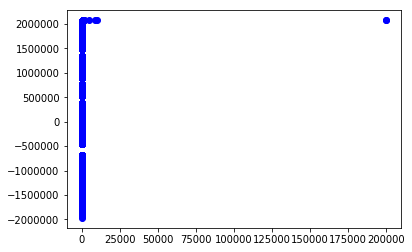

In [17]:
# Plotting an orderbook
AAPL_orders[0].plot()

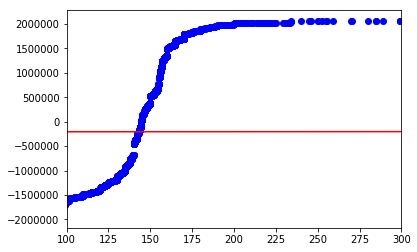

In [18]:
AAPL_orders[0].change_bounds((100,300))
AAPL_orders[0].plot()

Clearly the linear part of the curve is between 135 and 165, this is where the model would fit well. So the regression should be done on this data (similarly boundaries are found for all tickers).

In [19]:
AAPL_bounds = (140, 160)
AAPL_orders = make_class(AAPL, AAPL_bounds)
C_bounds = (66, 69)
C_orders = make_class(C, C_bounds)
GBX_bounds = (42.5, 45)
GBX_orders = make_class(GBX, GBX_bounds)
SPY_bounds = (241, 242.5)
SPY_orders = make_class(SPY, SPY_bounds)
THO_bounds = (101,104)
THO_orders = make_class(THO, THO_bounds)

In [20]:
# Problem 3.2
AAPL_beta = np.array([[order.time, order.beta]  for order in AAPL_orders])
C_beta = np.array([[order.time, order.beta]  for order in C_orders])
GBX_beta = np.array([[order.time, order.beta]  for order in GBX_orders])
SPY_beta = np.array([[order.time, order.beta]  for order in SPY_orders])
THO_beta = np.array([[order.time, order.beta]  for order in THO_orders])

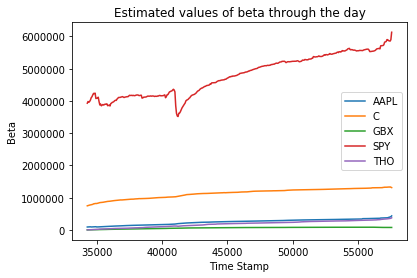

In [21]:
plt.plot(AAPL_beta[:,0], AAPL_beta[:,1], label='AAPL')
plt.plot(C_beta[:,0], C_beta[:,1], label='C')
plt.plot(GBX_beta[:,0], GBX_beta[:,1], label='GBX')
plt.plot(SPY_beta[:,0], SPY_beta[:,1], label='SPY')
plt.plot(THO_beta[:,0], THO_beta[:,1], label='THO')
plt.title('Estimated values of beta through the day')
plt.xlabel('Time Stamp')
plt.ylabel('Beta')
plt.legend()
plt.show()

In [22]:
p0_reg_AAPL = np.array([[order.time, -order.gamma / order.beta]  for order in AAPL_orders])
p0_act_AAPL = np.array([[order.time, order.get_p0()]  for order in AAPL_orders])

p0_reg_C = np.array([[order.time, -order.gamma / order.beta]  for order in C_orders])
p0_act_C = np.array([[order.time, order.get_p0()]  for order in C_orders])

p0_reg_GBX = np.array([[order.time, -order.gamma / order.beta]  for order in GBX_orders])
p0_act_GBX = np.array([[order.time, order.get_p0()]  for order in GBX_orders])

p0_reg_SPY = np.array([[order.time, -order.gamma / order.beta]  for order in SPY_orders])
p0_act_SPY = np.array([[order.time, order.get_p0()]  for order in SPY_orders])

p0_reg_THO = np.array([[order.time, -order.gamma / order.beta]  for order in THO_orders])
p0_act_THO = np.array([[order.time, order.get_p0()]  for order in THO_orders])

C:\Users\admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in double_scalars


In [23]:
err_AAPL = (sum(((p0_reg_AAPL[:,1] - p0_act_AAPL[:,1]) / p0_act_AAPL[:,1]) ** 2)) / len(p0_act_AAPL[:,1])
err_C = (sum(((p0_reg_C[:,1] - p0_act_C[:,1]) / p0_act_C[:,1]) ** 2)) / len(p0_act_C[:,1])
err_GBX = (sum(((p0_reg_GBX[:,1] - p0_act_GBX[:,1]) / p0_act_GBX[:,1]) ** 2)) / len(p0_act_GBX[:,1])
err_SPY = (sum(((p0_reg_SPY[:,1] - p0_act_SPY[:,1]) / p0_act_SPY[:,1]) ** 2)) / len(p0_act_SPY[:,1])
err_THO = (sum(((p0_reg_THO[:,1] - p0_act_THO[:,1]) / p0_act_THO[:,1]) ** 2)) / len(p0_act_THO[:,1])
print('% RMSE Error for AAPL, C, GBX, SPY & THO are:')
print(err_AAPL)
print(err_C)
print(err_GBX)
print(err_SPY)
print(err_THO)

% RMSE Error for AAPL, C, GBX, SPY & THO are:
0.0007478968298106637
5.658997528123259e-05
0.07113079149876372
0.00015476349872895075
0.005437301212083172


The error is small, indicating that the linear approximation is fairly representative of the linear region of the order book, hence this method is valid

Text(0, 0.5, 'p0')

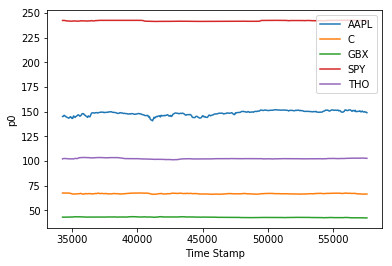

In [24]:
plt.plot(p0_reg_AAPL[:, 0], p0_reg_AAPL[:, 1], label='AAPL')
plt.plot(p0_reg_C[:, 0], p0_reg_C[:, 1], label='C')
plt.plot(p0_reg_GBX[:, 0], p0_reg_GBX[:, 1], label='GBX')
plt.plot(p0_reg_SPY[:, 0], p0_reg_SPY[:, 1], label='SPY')
plt.plot(p0_reg_THO[:, 0], p0_reg_THO[:, 1], label='THO')
plt.legend()
plt.xlabel('Time Stamp')
plt.ylabel('p0')

Text(0, 0.5, 'p0')

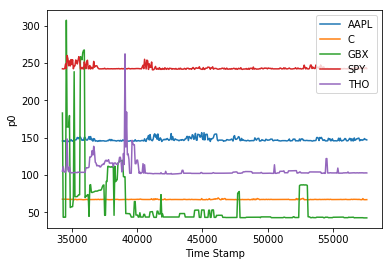

In [25]:
plt.plot(p0_act_AAPL[:, 0], p0_act_AAPL[:, 1], label='AAPL')
plt.plot(p0_act_C[:, 0], p0_act_C[:, 1], label='C')
plt.plot(p0_act_GBX[:, 0], p0_act_GBX[:, 1], label='GBX')
plt.plot(p0_act_SPY[:, 0], p0_act_SPY[:, 1], label='SPY')
plt.plot(p0_act_THO[:, 0], p0_act_THO[:, 1], label='THO')
plt.legend()
plt.xlabel('Time Stamp')
plt.ylabel('p0')